# UZOP - timski projekt
Hrvoje Molnar (0036534711)

Ana Francesca Stama (0036531912)

Luka Nestić (JMBAG)


In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

Prije svega, replicirat ćemo rezultate polaznog članka. Počinjemo s čišćenjem dobivenih podataka.

# Predobrada podataka

In [174]:
df=pd.read_csv("CBWDB.csv")
df

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,BPL,26.0,NaN,NaN,0.0,3.0,39.0,40.0,110.0,78.0,112.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1796,BPL,22.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1797,BPL,24.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,BPL,24.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vidimo da u ciljnom stupcu LNH ima nedostajućih vrijednosti. Morat ćemo ukloniti takve točke jer njihova nadopuna nema smisla. Ne možemo u klasifikacijskom problemu mijenjati ciljne klase.

In [175]:
df_filtered=df[df["LNH"].isna()==False]
print("Nedostajuće vrijednosti po stupcima:")
print(df_filtered.isna().sum())
print("\nBroj redaka nakon filtriranja: ",len(df_filtered))

Nedostajuće vrijednosti po stupcima:
SEC             200
Age(years)        3
Height(cm)      128
Bgroup          367
Parity            0
ANC               0
Iwt(kg)          12
FWt(kg)          13
IBP_sys           4
IBP_dias          4
FBP_sys           6
FBP_dias          6
IHb(gm%)        103
FHb(gm%)        102
BS(RBS)         531
Term/Preterm    133
Sex              11
BWt(kg)           0
LNH               0
dtype: int64

Broj redaka nakon filtriranja:  1072


U datasetu vidimo da preko pola vrijednosti BS(RBS) nedostaje! Procjenjujemo da uklanjanjem redova s nepostojećim vrijednostima ove varijable možemo doći do približnog broja filtriranih podataka u članku (445) pa ćemo tako i postupiti. Usput ćemo ukloniti i točke s marginalnim vrijednostima: LNH vrijednosti 3 (pretila novorođenčad) i Sex u vrijednosti T. Takvih je podataka vrlo, vrlo malo pa brojem redova sigurno nećemo pasti ispod okvirnih 445 redaka dataframea.


In [176]:
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T") & (df_filtered["BS(RBS)"].isna()==False)] 

print(df_filtered.isna().sum())
print("Broj točaka: ",len(df_filtered))

SEC             35
Age(years)       0
Height(cm)       0
Bgroup          20
Parity           0
ANC              0
Iwt(kg)          0
FWt(kg)          0
IBP_sys          0
IBP_dias         0
FBP_sys          0
FBP_dias         0
IHb(gm%)         0
FHb(gm%)         0
BS(RBS)          0
Term/Preterm     2
Sex              1
BWt(kg)          0
LNH              0
dtype: int64
Broj točaka:  537


Sve NaN vrijednosti pripadaju kategoričkim varijablama. Pošto ih je relativno malo, zamijenit ćemo ih modom pripadajućeg stupca.

In [177]:
cat_cols=["SEC","Sex","Term/Preterm","Bgroup"]
for col in cat_cols:
    df_filtered[col]=df_filtered[col].fillna(df_filtered[col].mode()[0])

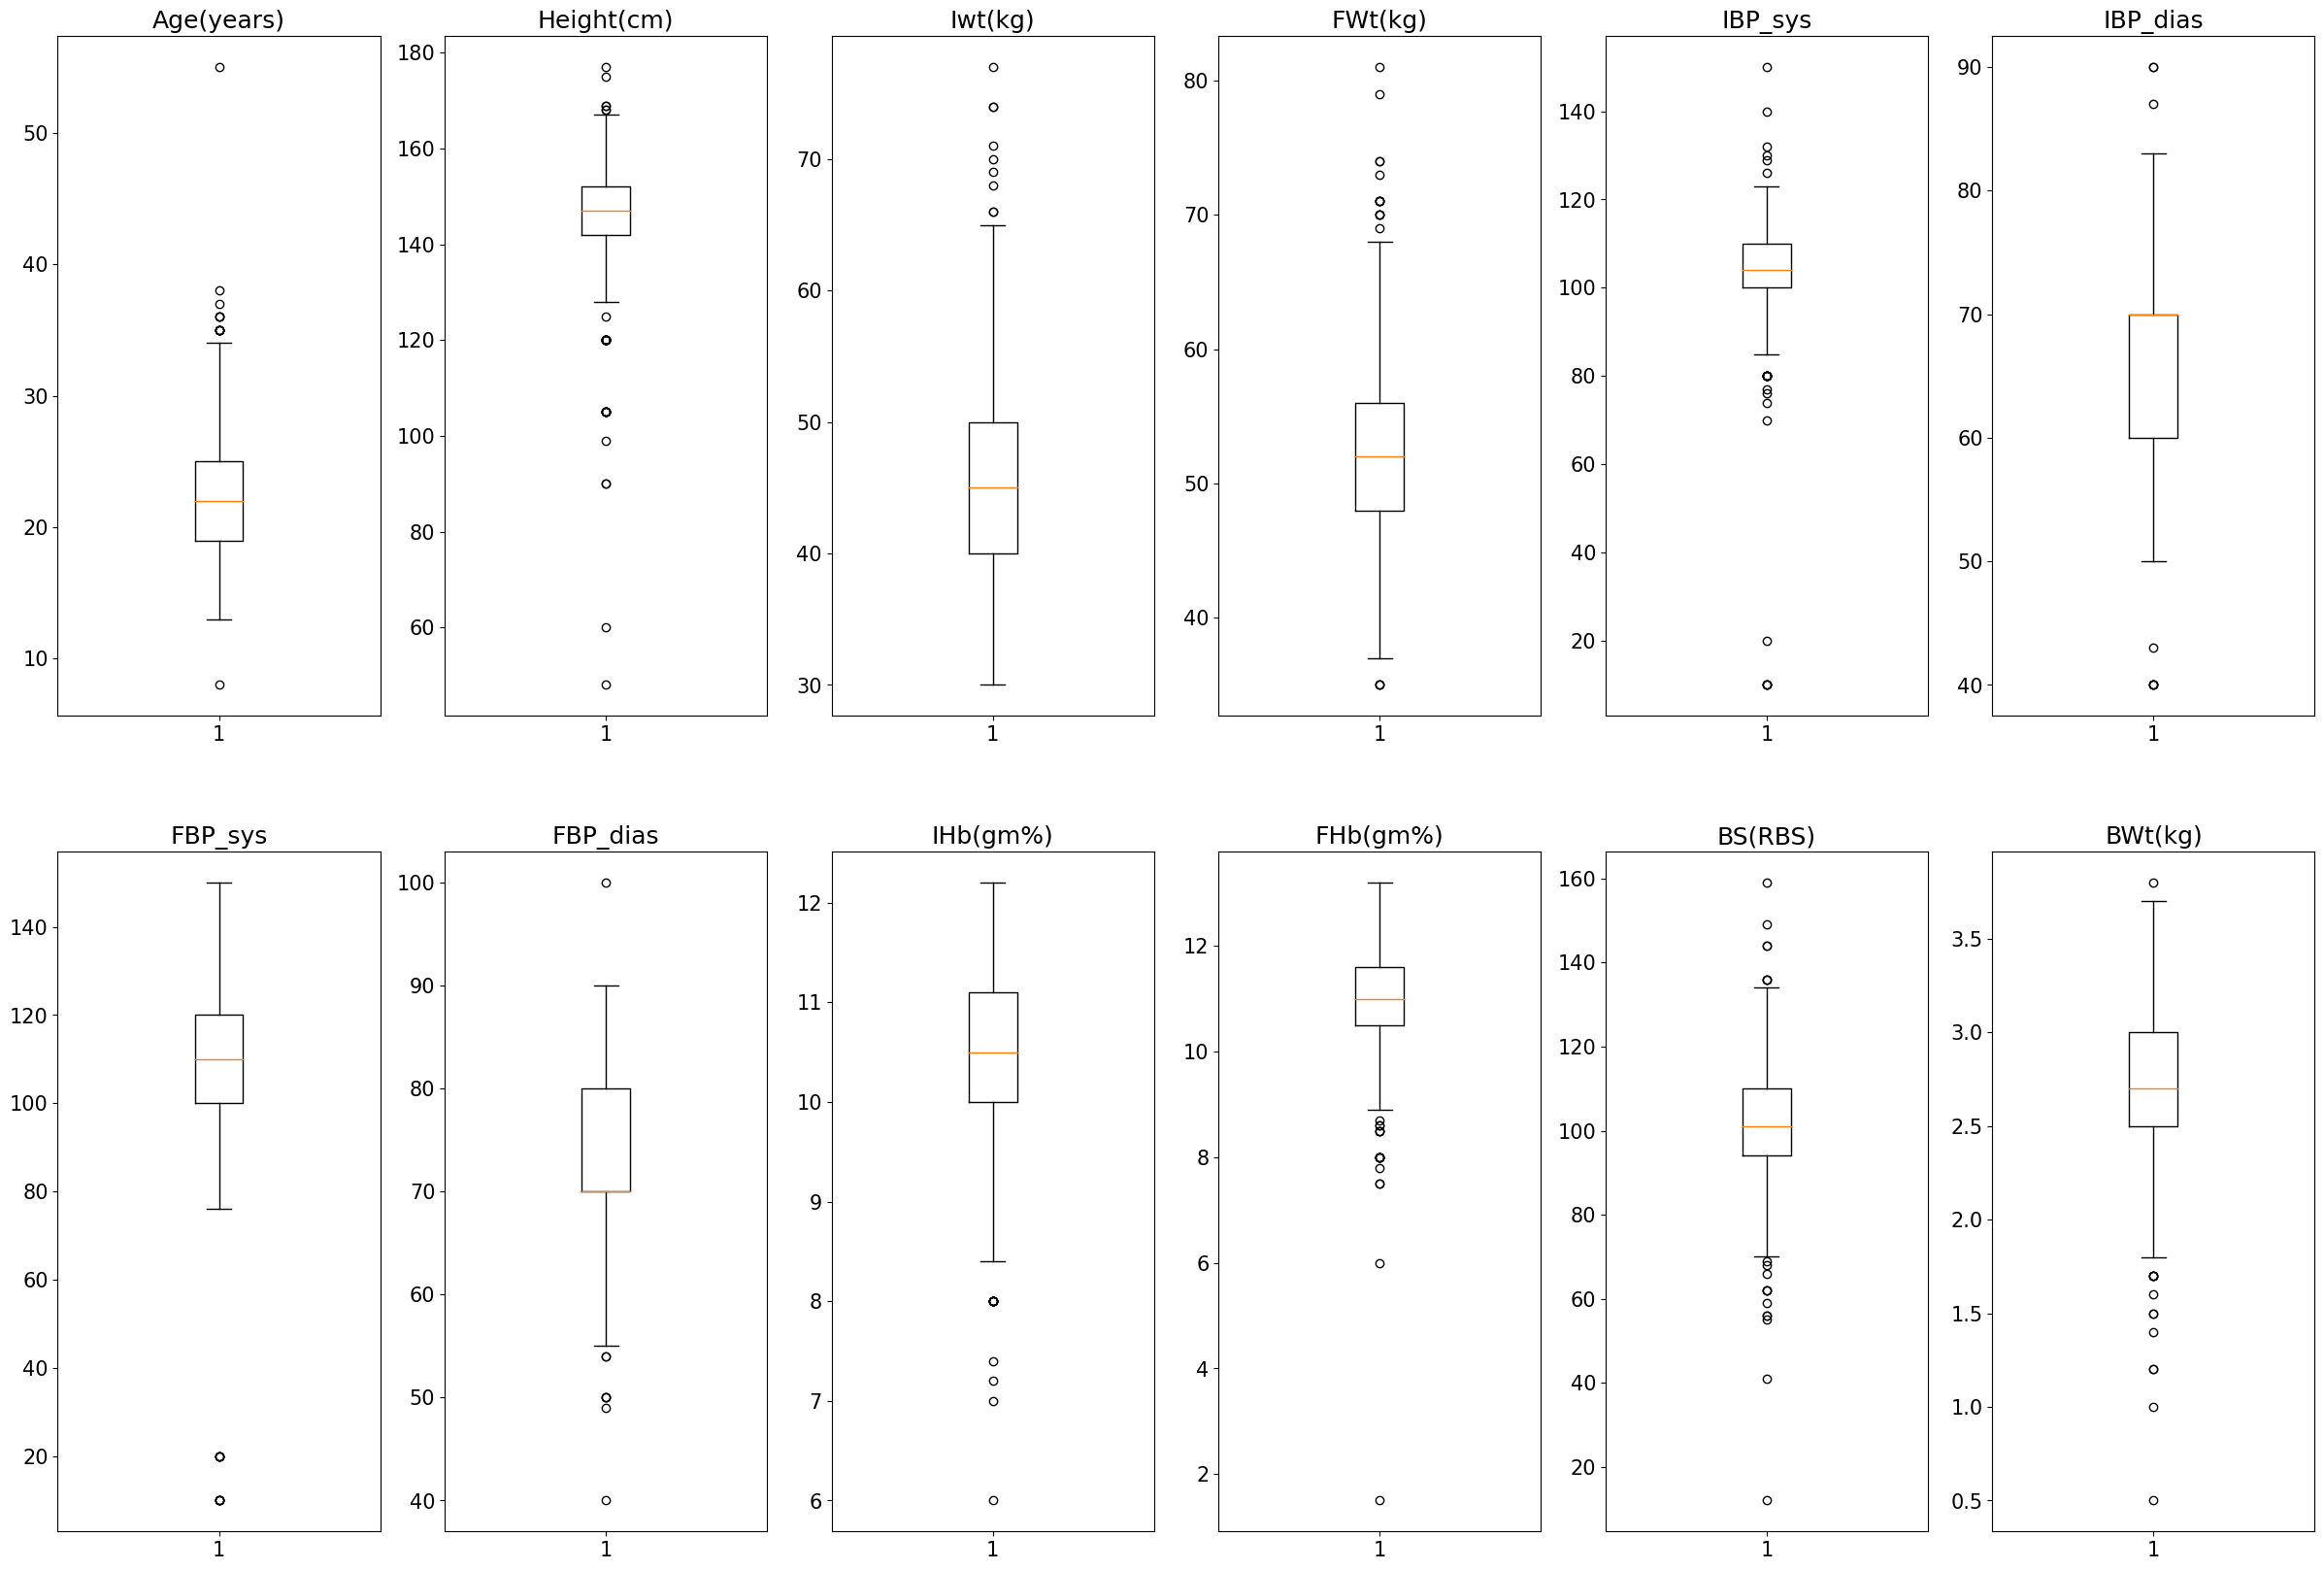

In [178]:
cols=["Age(years)","Height(cm)","Iwt(kg)","FWt(kg)","IBP_sys","IBP_dias","FBP_sys","FBP_dias","IHb(gm%)","FHb(gm%)","BS(RBS)","BWt(kg)"]
fig,ax=plt.subplots(2,6,figsize=(30,20))
i,j=0,0
for col in cols:
    ax[i,j].boxplot(df_filtered[col])
    ax[i,j].set_title(col)
    j+=1
    if j==6:
        i,j=i+1,0
        

Za kraj, kategoričke značajke pretvaramo u numeričke, a numeričke normaliziramo. Nakon cijelog postupka, ostaje nam 421 uzorak, malo manje nego u članku.

In [179]:
for col in df_filtered.columns:
    if col in cat_cols:
        df_filtered[col]=df_filtered[col].astype('category').cat.codes
    else:
        df_filtered[col]=(df_filtered[col]-df_filtered[col].min())/(df_filtered[col].max()-df_filtered[col].min())

df_filtered

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,1,0.319149,0.759690,1,0.166667,1.000000,0.085106,0.152174,0.757143,0.76,0.785714,0.500000,0.645161,1.000000,0.530612,1,0,0.666667,1.0
1,1,0.361702,0.906977,8,0.166667,0.666667,0.808511,0.782609,0.614286,0.60,0.714286,0.533333,0.709677,0.811966,0.571429,1,1,0.727273,1.0
2,1,0.340426,0.829457,5,0.166667,0.666667,0.404255,0.434783,0.578571,0.24,0.714286,0.500000,0.806452,0.863248,0.612245,1,1,0.575758,0.0
3,1,0.234043,0.821705,8,0.166667,0.333333,0.404255,0.326087,0.571429,0.24,0.642857,0.333333,0.645161,0.777778,0.619048,1,0,0.636364,1.0
4,1,0.276596,0.790698,8,0.166667,1.000000,0.234043,0.282609,0.642857,0.40,0.714286,0.500000,0.483871,0.743590,0.591837,1,0,0.545455,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1,0.425532,0.728682,8,0.166667,1.000000,0.255319,0.282609,0.642857,0.52,0.671429,0.483333,0.629032,0.811966,0.707483,1,1,0.757576,1.0
1589,1,0.468085,0.751938,8,0.166667,0.666667,0.489362,0.478261,0.707143,0.48,0.800000,0.600000,0.693548,0.777778,0.707483,0,1,0.606061,1.0
1600,1,0.297872,0.790698,5,0.000000,1.000000,0.468085,0.500000,0.671429,0.62,0.657143,0.350000,0.403226,0.811966,0.510204,1,1,0.818182,1.0
1607,1,0.297872,0.689922,5,0.000000,1.000000,0.276596,0.282609,0.671429,0.44,0.700000,0.366667,0.645161,0.786325,0.408163,1,0,0.757576,1.0


# Vizualizacija

Kako bismo dobili uvid u strukturu podataka te moguće probleme, provodimo analizu glavnih komponenti (PCA). PCA je tehnika za smanjenje dimenzionalnosti podataka koja pronalazi osi najveće varijabilnosti podataka te preslikava $n$-dimenzionalni prostor podataka u $k$-dimenzionalni, gdje $n>k$. Kao takva, vezana je uz varijance naših značajki.

In [180]:
#Pretvorba u ndarray i train-test podjela s uključenom stratifikacijom
X=df_filtered.drop(columns="LNH").to_numpy()
y=df_filtered["LNH"].to_numpy()

sorted_vars = dict(zip(np.array(df_filtered.drop(columns="LNH").columns), np.round(np.var(X,axis=0),3)))
sorted_vars = dict(sorted(sorted_vars.items(), key=lambda item: item[1], reverse=True))
print("Column variances:") 
sorted_vars


Column variances:


{'Bgroup': 7.31,
 'Sex': 0.249,
 'SEC': 0.205,
 'Term/Preterm': 0.099,
 'ANC': 0.05,
 'IBP_dias': 0.025,
 'IHb(gm%)': 0.025,
 'FWt(kg)': 0.023,
 'Iwt(kg)': 0.022,
 'FBP_dias': 0.017,
 'BWt(kg)': 0.016,
 'Parity': 0.015,
 'FBP_sys': 0.014,
 'BS(RBS)': 0.011,
 'Height(cm)': 0.01,
 'Age(years)': 0.009,
 'IBP_sys': 0.009,
 'FHb(gm%)': 0.007}

Vidimo da je $Var(\text{Bgroup})$ puno veća od ostalih. Pogledajmo kako izgledaju dvodimenzionalne PCA i t-SNE preslike podataka s i bez tog stupca.

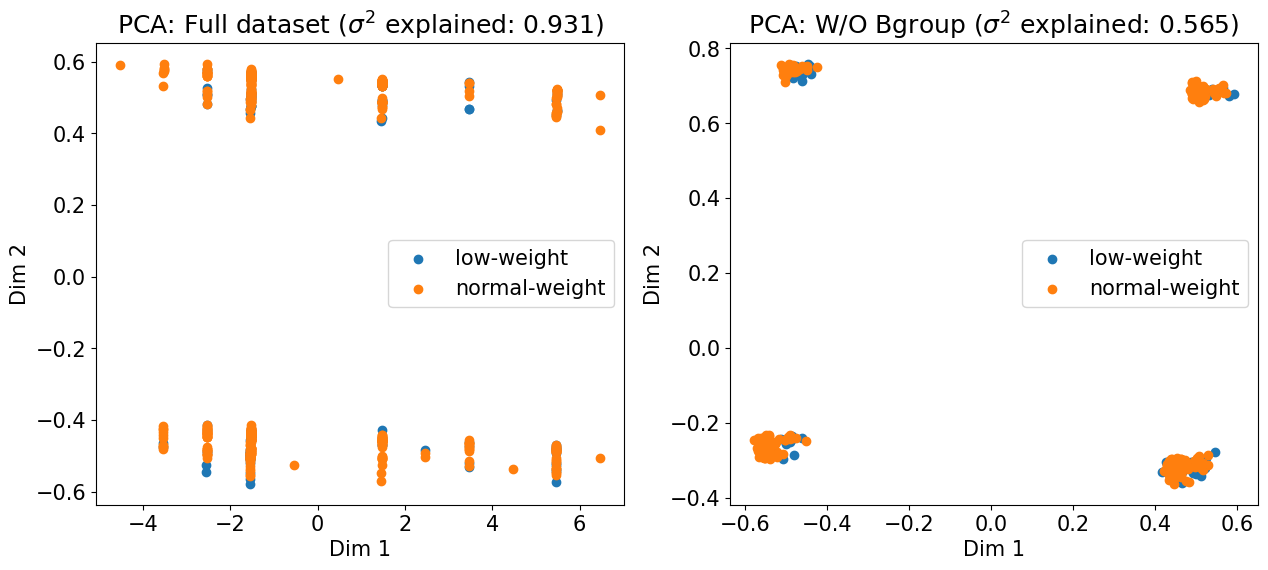

In [181]:
pca=PCA(n_components=2)
fig,ax=plt.subplots(1,2,figsize=(15,6))

X_pca1=pca.fit_transform(X)
ax[0].scatter(X_pca1[np.where(y==0)[0], 0], X_pca1[np.where(y==0)[0], 1], label="low-weight")
ax[0].scatter(X_pca1[np.where(y==1)[0], 0], X_pca1[np.where(y==1)[0], 1], label="normal-weight")
ax[0].set_title("PCA: Full dataset ($\sigma^2$ explained: {:.3f})".format(sum(pca.explained_variance_ratio_)))
ax[0].set_xlabel("Dim 1")
ax[0].set_ylabel("Dim 2")
ax[0].legend()

X_pca2=pca.fit_transform(np.delete(X,3,axis=1))
ax[1].scatter(X_pca2[np.where(y==0)[0], 0], X_pca2[np.where(y==0)[0], 1], label="low-weight")
ax[1].scatter(X_pca2[np.where(y==1)[0], 0], X_pca2[np.where(y==1)[0], 1], label="normal-weight")
ax[1].set_title("PCA: W/O Bgroup ($\sigma^2$ explained: {:.3f})".format(sum(pca.explained_variance_ratio_)))
ax[1].set_xlabel("Dim 1")
ax[1].set_ylabel("Dim 2")
ax[1].legend()

plt.show()

c:\Users\afs\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\afs\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\afs\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\afs\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


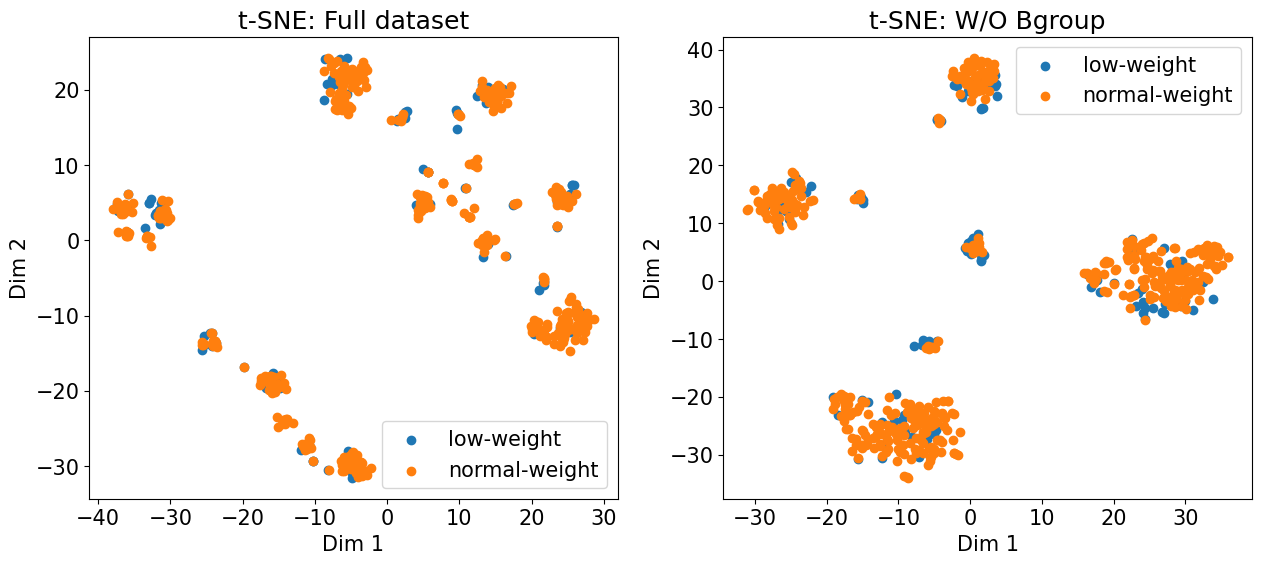

In [182]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
fig,ax=plt.subplots(1,2,figsize=(15,6))

X_tsne1=tsne.fit_transform(X)
ax[0].scatter(X_tsne1[np.where(y==0)[0], 0], X_tsne1[np.where(y==0)[0], 1], label="low-weight")
ax[0].scatter(X_tsne1[np.where(y==1)[0], 0], X_tsne1[np.where(y==1)[0], 1], label="normal-weight")
ax[0].set_title("t-SNE: Full dataset")
ax[0].set_xlabel("Dim 1")
ax[0].set_ylabel("Dim 2")
ax[0].legend()

X_tsne2=tsne.fit_transform(np.delete(X,3,axis=1))
ax[1].scatter(X_tsne2[np.where(y==0)[0], 0], X_tsne2[np.where(y==0)[0], 1], label="low-weight")
ax[1].scatter(X_tsne2[np.where(y==1)[0], 0], X_tsne2[np.where(y==1)[0], 1], label="normal-weight")
ax[1].set_title("t-SNE: W/O Bgroup")
ax[1].set_xlabel("Dim 1")
ax[1].set_ylabel("Dim 2")
ax[1].legend()

plt.show()

Ovdje imamo dva komentara. Prvo, klase nisu razdvojene ni na jednom grafu (micanje ostalih značajki s visokom varijancom to ne mijenja). To nam govori da će klasifikacija vrlo vjerojatno biti teška. Drugo, micanjem Bgroup stupca, objašnjenja varijanca smanjena je za 45%! Vidimo da je Bgroup veliki faktor za opisivanje podataka. Međutim, sjećamo se da je bilo jako puno nedostajućih vrijednosti u polaznom datasetu (367/1072 redova kojima LNH nije NaN $\approx$ 34%). Također, korelacija između tog stupca i BWt(kg) je skoro zanemariva:

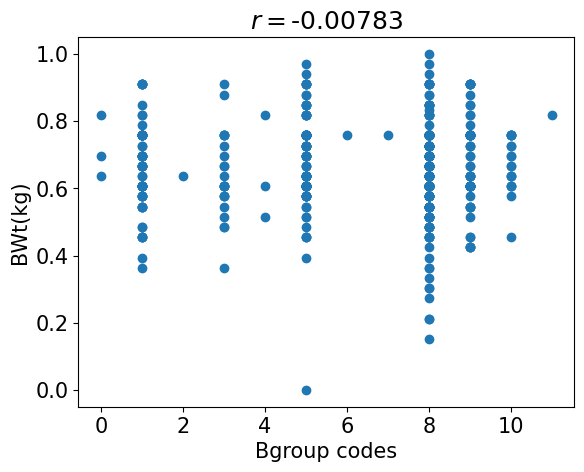

In [183]:
plt.scatter(df_filtered["Bgroup"],df_filtered["BWt(kg)"])
plt.xlabel("Bgroup codes")
plt.ylabel("BWt(kg)")
plt.title("$r=${:.5f}".format(np.corrcoef(df_filtered["Bgroup"],df_filtered["BWt(kg)"])[0,1]))
plt.show()

Iz problema velikog broja NaN vrijednosti i nepostojeće koreliranosti zaključujemo da se stupac Bgroup može ukloniti iz skupa podataka. To ćemo napraviti tek kasnije pri poboljšanju rezultata članka. Sad možemo krenuti u implementaciju modela!

# Modeli iz članka (GNB i RFC)

Kao u članku, 30% podataka ostavljamo za testiranje modela. Također koristimo stratifikaciju zbog iznimno nebalansiranog skupa podataka (>80% vrijednosti pripada klasi $y=1$). Za provjeru modela koristimo iste metrike kao u članku:

1. $Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

2. $Precision=\frac{TP}{TP+FP}$

3. $Recall=\frac{TP}{TP+FN}$

4. $F1=\frac{Precision \times Recall}{Precision + Recall}$

Koristi se više metrika zbog prijespomenute neuravnoteženosti klasa. Također, sve se metrike, osim $Accuracy$ mijenjaju kada zamijenimo pozitivnu i negativnu klasu ($TP$ u brojniku!). Stoga je bitno provjeriti metrike i za zamijenjene vrijednosti $y$.

In [184]:
#fja za provjeru metrika te ispis matrice konfuzije

def test_model(classifier,X_train,y_train,X_test,y_test):
    classifier.fit(X_train,y_train)

    y_pred_train=classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)

    print("Train accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_train,y_pred_train),precision_score(y_train,y_pred_train),recall_score(y_train,y_pred_train),f1_score(y_train,y_pred_train)))

    print("Test accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_test,y_pred_test),precision_score(y_test,y_pred_test),recall_score(y_test,y_pred_test),f1_score(y_test,y_pred_test)))

    print("Confusion matrix: \n",confusion_matrix(y_test,y_pred_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
len(y_train),len(y_test)

(375, 162)

Prvi isprobani model u članku je Gaussian naive Bayes klasifikator.

In [185]:
gnb=GaussianNB()

test_model(gnb,X_train,y_train,X_test,y_test)
print("\n")
test_model(gnb,X_train,1-y_train,X_test,1-y_test)

Train accuracy, precision, recall, F1: 0.875 0.918 0.927 0.922
Test accuracy, precision, recall, F1: 0.809 0.884 0.877 0.880
Confusion matrix: 
 [[ 17  15]
 [ 16 114]]


Train accuracy, precision, recall, F1: 0.875 0.690 0.662 0.676
Test accuracy, precision, recall, F1: 0.809 0.515 0.531 0.523
Confusion matrix: 
 [[114  16]
 [ 15  17]]


Vidimo vrlo visoke iznose metrika u oba slučaja. To nam govori da imamo vrlo dobar model! Isprobat ćemo još i Random Forest klasifikator. To je tzv ensemble model strojnog učenja, gdje se izlaz određuje "glasanjem" više jednostavnijih modela (ovdje, stabla odluke). Za razliku od prije, sad ćemo mijenjati parametre modela.

Uslijed ovoga, imali smo eureka trenutak: "**Čekaj malo**! U članku je kao značajka korištena težina bebe BWt(kg), a predviđena je klasa raspon težina (pothranjena, normalna i pretila beba). Nije li to... **Varanje**?! Kako bismo testirali ovo razmišljanje, napravit ćemo rubno jednostavan Random forest model (samo tri stabla s jednom podjelom listova) i vizualizirati da vidimo po kojem kriteriju nastaju čvorovi. Kao u članku, koristit ćemo Bootstraping za izradu stabala. Kriterij podjele bit će nam entropija.

Train accuracy, precision, recall, F1: 0.992 0.997 0.993 0.995
Test accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Confusion matrix: 
 [[ 32   0]
 [  0 130]]
Train accuracy, precision, recall, F1: 0.992 0.973 0.986 0.980
Test accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Confusion matrix: 
 [[130   0]
 [  0  32]]


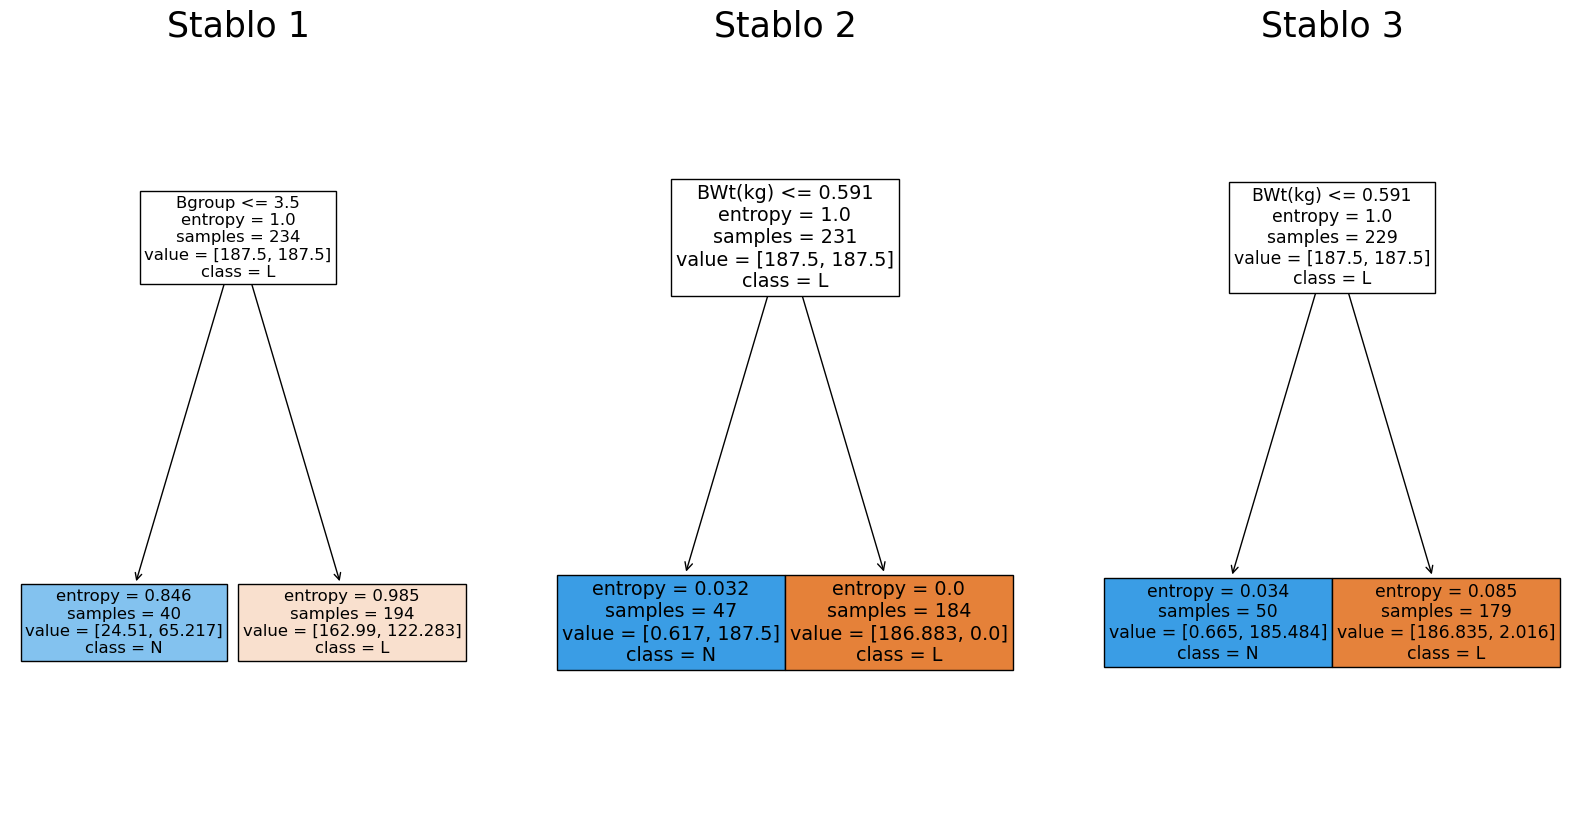

In [186]:
rfc=RandomForestClassifier(n_estimators=3,criterion="entropy",random_state=42,bootstrap=True,max_depth=1,class_weight="balanced_subsample")

test_model(rfc,X_train,y_train,X_test,y_test)
test_model(rfc,X_train,1-y_train,X_test,1-y_test)

fn=df_filtered.columns
cn=["L","N"]
fig,ax=plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    tree.plot_tree(rfc.estimators_[i],feature_names=fn,class_names=cn,filled = True,ax=ax[i])
    ax[i].set_title('Stablo ' + str(i+1), fontsize = 25)

Znali smo! Dva od tri stabla dijele po istom kriteriju BWt(kg), čak je i granica ista! De facto, to je jedino stablo koje donosi odluku. Dobili smo savršeni klasifikator, baš kao u članku, isključivo na temelju težine bebe.

# Jesu li rezultati članka valjani?

Gornji zaključak upućuje na to da postupak u članku nije dobar. Ako su težinske kategorije bebe L (low-weight), N (normal-weight) i H (high-weight) jednoznačno određene rasponom masa koji se ne preklapaju, iz BWt(kg) jednoznačno se može odrediti izlazna klasa $y$. Pokušajmo pronaći te intervale za klase L i N.

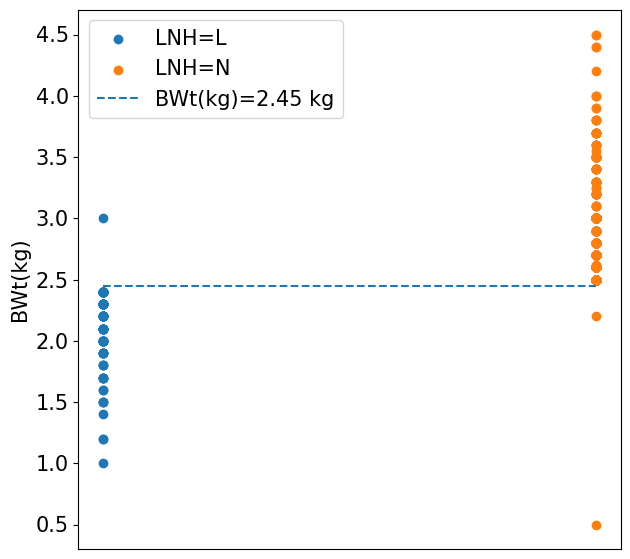

In [187]:
df_filtered=df[df["LNH"].isna()==False]
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T")] 

fig=plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.scatter(np.ones(len(df_filtered[df_filtered["LNH"]==1])),df_filtered[df_filtered["LNH"]==1]["BWt(kg)"],label="LNH=L")
plt.scatter(np.ones(len(df_filtered[df_filtered["LNH"]==2]))*2,df_filtered[df_filtered["LNH"]==2]["BWt(kg)"],label="LNH=N")
plt.plot([1,2],[2.45,2.45],"--",label="BWt(kg)=2.45 kg")
plt.xticks([])
plt.ylabel("BWt(kg)")
plt.legend()
plt.show()

Vidimo da u skupu podataka čak i ovdje imamo problem! Postoje bebe označene klasom N s manjom masom od beba označenih klasom L i obratno. Još jedan u nizu stvari koje treba popraviti... 

Kako bi masa bebe jednoznačno označavala klasu kojoj ona pripada, odredit ćemo threshold od na temelju vizualizacije te zadržati samo zapise čija je težina bebe manja ili jednaka thresholdu, a klasificirana je kao L, te zapise čija je težina bebe veća od thresholda, a klasificirana je kao N.

In [169]:
thresh = 2.45
df_filtered_out = df_filtered.loc[((df_filtered["BWt(kg)"]<=thresh) & (df_filtered["LNH"]==1)) | 
                              ((df_filtered["BWt(kg)"]>thresh) & (df_filtered["LNH"]==2))]

print(f'Broj zapisa prije izbacivanja: {len(df_filtered)}')
print(f'Broj zapisa nakon izbacivanja: {len(df_filtered_out)}')

Broj zapisa prije izbacivanja: 1066
Broj zapisa nakon izbacivanja: 1063


Kako bismo spriječili **varanje** i dobili prave rezultate dobivene modelima korištenim u članku, maknut ćemo varijablu _BWt(kg)_ iz skupa podataka te ponovno isprobati korištene modele. Ovaj put ćemo dobiti njihove stvarne metrike. Napravit ćemo istu predobradu podataka kao i ranije.

In [190]:
df_clean = df_filtered.drop(columns="BWt(kg)")
df_clean = df_clean[(df_clean["LNH"]!=3) & (df_clean["Sex"]!="T") & (df_clean["BS(RBS)"].isna()==False)] 
cols=["Age(years)","Height(cm)","Iwt(kg)","FWt(kg)","IBP_sys","IBP_dias","FBP_sys","FBP_dias","IHb(gm%)","FHb(gm%)","BS(RBS)","BWt(kg)"]
cat_cols=["SEC","Sex","Term/Preterm","Bgroup"]
for col in cat_cols:
    df_clean[col]=df_clean[col].fillna(df_clean[col].mode()[0])
for col in df_clean.columns:
    if col in cat_cols:
        df_clean[col]=df_clean[col].astype('category').cat.codes
    else:
        df_clean[col]=(df_clean[col]-df_clean[col].min())/(df_clean[col].max()-df_clean[col].min())

X = df_clean.drop(columns='LNH').to_numpy()
y = df_clean['LNH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
len(y_train),len(y_test)

(375, 162)

Prvo ćemo usporediti razultate Gaussian Naive Bayes modela s i bez redudantne varijable _BWt(kg)_.

In [192]:
gnb=GaussianNB()
test_model(gnb,X_train,y_train,X_test,y_test)
print("\n")
test_model(gnb,X_train,1-y_train,X_test,1-y_test)

Train accuracy, precision, recall, F1: 0.797 0.869 0.880 0.875
Test accuracy, precision, recall, F1: 0.741 0.824 0.862 0.842
Confusion matrix: 
 [[  8  24]
 [ 18 112]]


Train accuracy, precision, recall, F1: 0.797 0.486 0.459 0.472
Test accuracy, precision, recall, F1: 0.741 0.308 0.250 0.276
Confusion matrix: 
 [[112  18]
 [ 24   8]]


Rezultati nisu nužno loši, ali svakako su puno lošiji od slučaja kad u model uključimo varijablu _BWt(kg)_, što je logično. Zaključak je da model iz članka nije toliko dobar koliko su autori zaključili.

Model koji je zanimljiviji, a koji smo replicirali, je Random Forest. Vidjeli smo da je prethodno model zaključivao klasu bebe na temelju težine bebe u čak 2 od 3 stabla. Petpostavka je da će rezultati modela treniranog na podacima iz kojih je izbačena težina bebe biti puno lošiji.

Train accuracy, precision, recall, F1: 0.579 0.856 0.571 0.685
Test accuracy, precision, recall, F1: 0.519 0.833 0.500 0.625
Confusion matrix: 
 [[19 13]
 [65 65]]
Train accuracy, precision, recall, F1: 0.579 0.259 0.608 0.363
Test accuracy, precision, recall, F1: 0.519 0.226 0.594 0.328
Confusion matrix: 
 [[65 65]
 [13 19]]


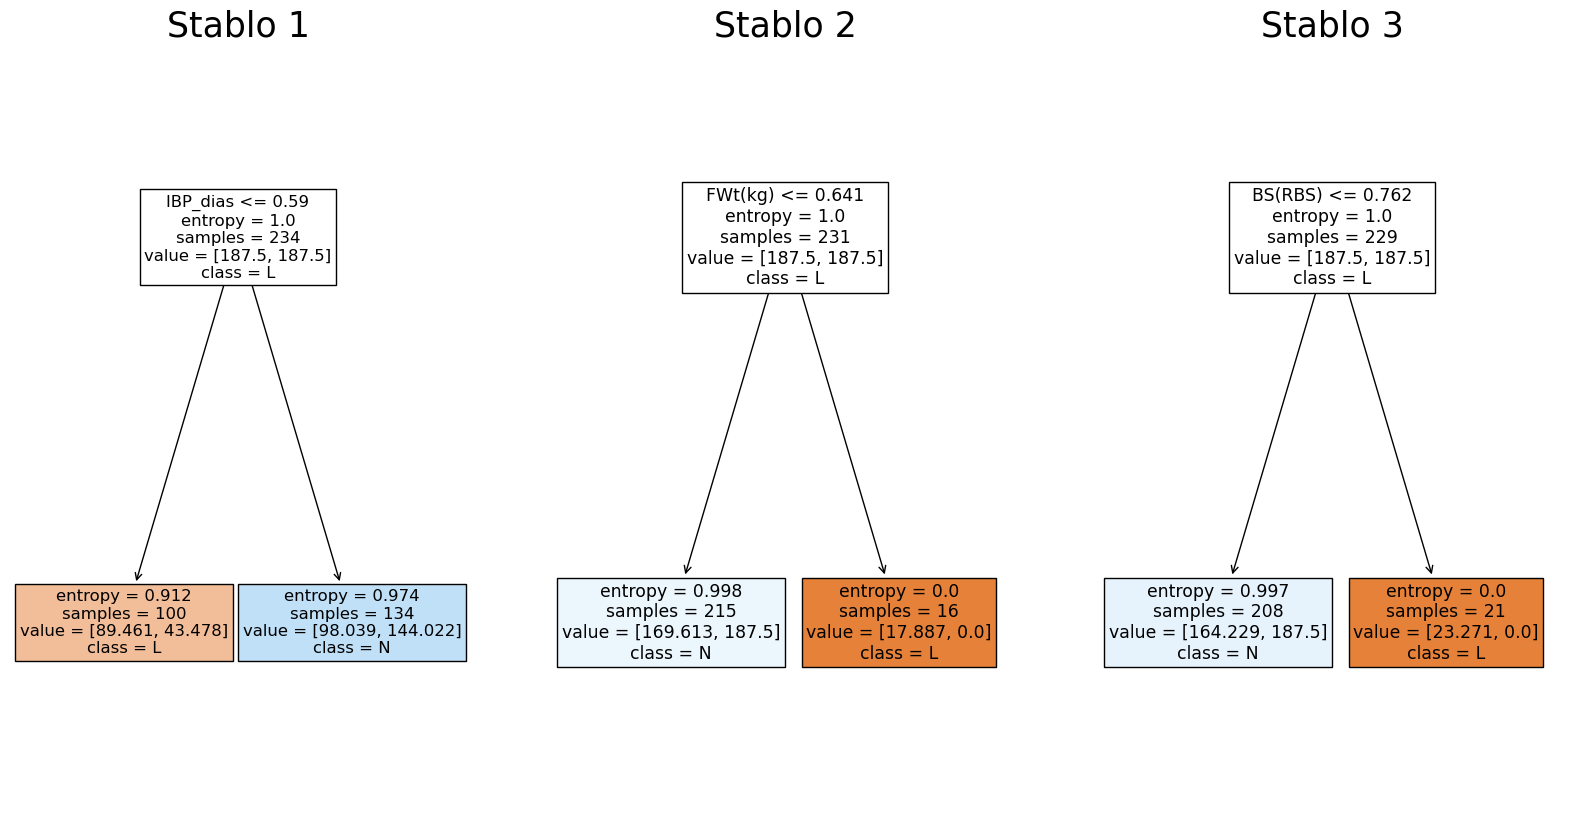

In [193]:
rfc=RandomForestClassifier(n_estimators=3,criterion="entropy",random_state=42,bootstrap=True,max_depth=1,class_weight="balanced_subsample")

test_model(rfc,X_train,y_train,X_test,y_test)
test_model(rfc,X_train,1-y_train,X_test,1-y_test)

fn=df_filtered.columns
cn=["L","N"]
fig,ax=plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    tree.plot_tree(rfc.estimators_[i],feature_names=fn,class_names=cn,filled = True,ax=ax[i])
    ax[i].set_title('Stablo ' + str(i+1), fontsize = 25)

Kao što smo i pretpostavili, rezultati su puno lošiji od onih dobivenih uključivanjem težine bebe u model. Ova dva modela slušit će nam kao benchmark u nastavku ove bilježnice. Pokušat ćemo poboljšati rezultate korištenjem drugačijih metoda predobrade podataka i modela strojnog učenja.

#------------------------------------------------------------------NAPRAVLJENO DO OVDI----------------------------------------------------------------------------------------#

U datasetu postoje problemi stršećih uzoraka. Uklonit ćemo i te podatke. Stršeće podatke definirat ćemo statistički kao podatke koji se nalaze izvan intervala $[Q1-1.5*IQR, Q3+1.5*IQR]$, gdje je $IQR = Q3-Q1$.

In [ ]:
print('Broj zapisa prije izbacivanja outliera:', len(df_filtered))
df_copy = df_filtered.copy()

for col in cols:
    Q1 = np.percentile(df_copy[col], 25, method='midpoint')
    Q3 = np.percentile(df_copy[col], 75, method='midpoint')
    IQR = Q3 - Q1
    df_copy = df_copy.loc[(df_copy[col]>Q1-1.5*IQR) & (df_copy[col]<Q3+1.5*IQR)]

df_filtered=df_copy.copy()
print('Broj zapisa nakon izbacivanja outliera:', len(df_copy))
print("\nNedostajuće vrijednosti po stupcima:")
print(df_filtered.isna().sum())

Korelacija Bgroup-BWt:
-0.07173160981151736

Korelacija BS-BWt:
0.16565989471456471


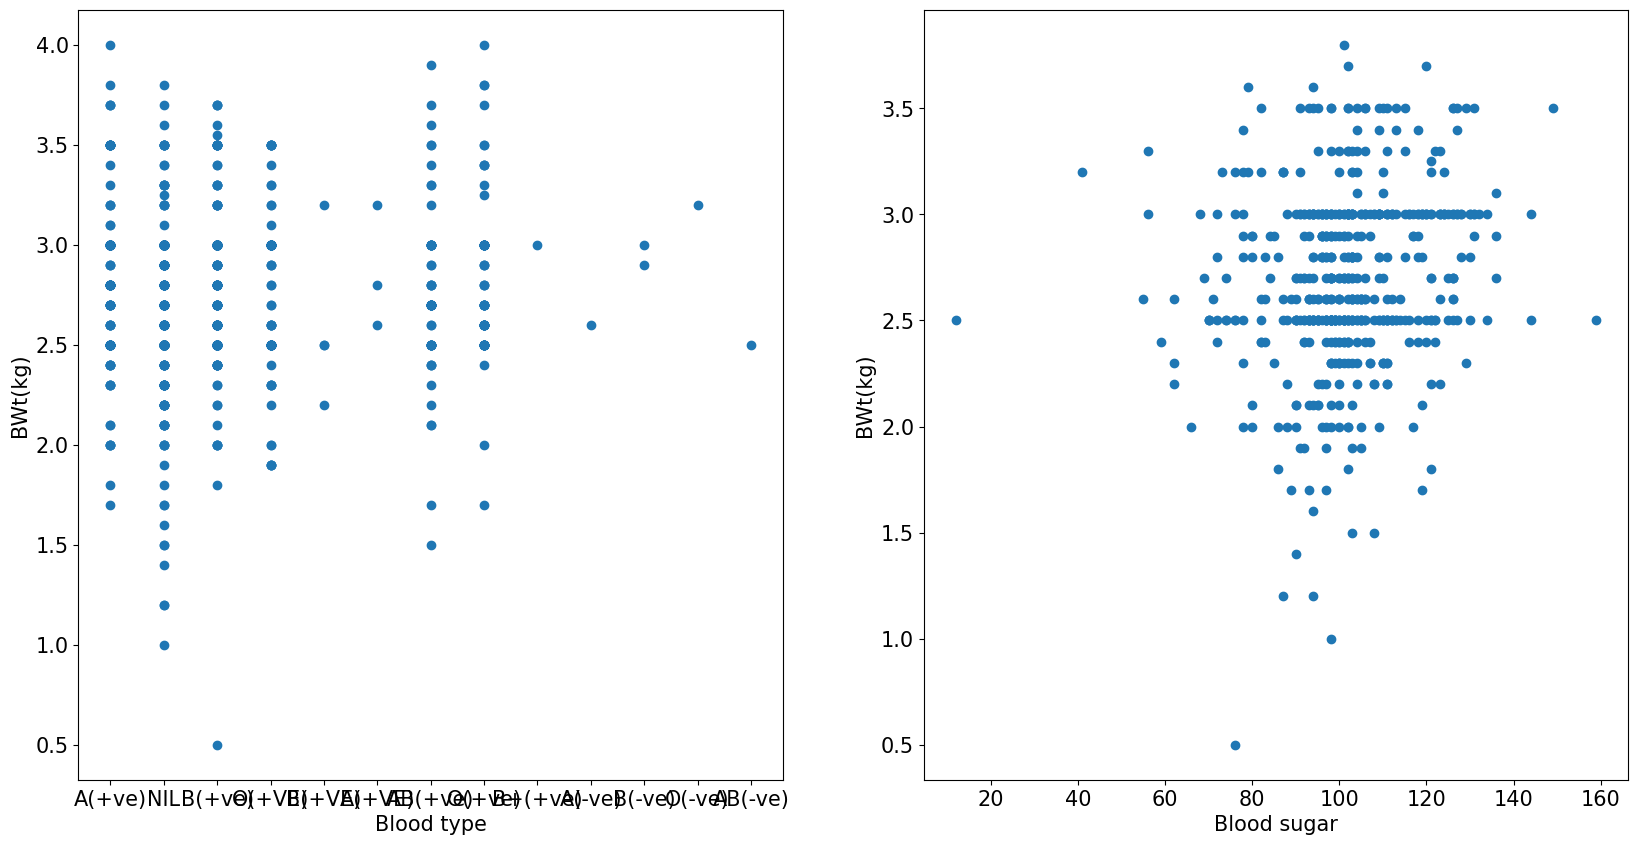

In [42]:
df_bgroup=df_filtered[df_filtered["Bgroup"].isna()==False]


print("Korelacija Bgroup-BWt:")
print(np.corrcoef(df_bgroup["Bgroup"].astype("category").cat.codes,df_bgroup["BWt(kg)"])[0,1])

fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(df_bgroup["Bgroup"],df_bgroup["BWt(kg)"])
ax[0].set_xlabel("Blood type")
ax[0].set_ylabel("BWt(kg)")

df_bs=df_filtered[df_filtered["BS(RBS)"].isna()==False]

print("\nKorelacija BS-BWt:")
print(np.corrcoef(df_bs["BS(RBS)"],df_bs["BWt(kg)"])[0,1])

ax[1].scatter(df_bs["BS(RBS)"],df_bs["BWt(kg)"])
ax[1].set_xlabel("Blood sugar")
ax[1].set_ylabel("BWt(kg)")
plt.show()

In [43]:
np.var(X,axis=0)

array([0.19854323, 0.03042766, 0.02741951, 2.5556615 , 0.08131019,
       0.061044  , 0.02922874, 0.04442437, 0.02571426, 0.03856301,
       0.01815431, 0.03468056, 0.04593368, 0.02978496, 0.03243216,
       0.09732511, 0.24949081, 0.03084121])

In [44]:
svc=SVC(kernel="rbf",gamma=.3,C=1,class_weight="balanced")

test_model(svc,X_train[:,1:-2],y_train,X_test[:,1:-2],y_test)

Train accuracy, precision, recall, F1: 0.762 0.917 0.781 0.844
Test accuracy, precision, recall, F1: 0.654 0.828 0.733 0.778
Confusion matrix: 
 [[ 6 16]
 [28 77]]


In [125]:
#def moving_average_categorical(df,columns,window_size):
    for col in columns:
        for i in range(len(df)):
            if pd.isna(df.loc[i, col]):
                start = max(0, i - window_size)
                end = min(len(df), i + window_size + 1)
    
                nearby_values = df[col].iloc[start:end].dropna()

                df.at[i, col] = nearby_values.mode()
                
    return df

#df1=moving_average_categorical(df,["Sex"],3)
#plt.plot(df1["BS(RBS)"])

IndentationError: unexpected indent (2165512536.py, line 2)

In [76]:
knn=KNeighborsClassifier(n_neighbors=1,weights="distance")

test_model(knn,X_train[:,],y_train,X_test[:,:],y_test)

Train accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Test accuracy, precision, recall, F1: 0.781 0.846 0.892 0.868
[[ 8 18]
 [12 99]]


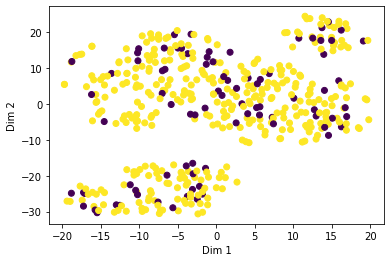

In [113]:
tsne=TSNE(n_components=2,n_iter=1000,perplexity=30,random_state=42)
X_tsne=tsne.fit_transform(X[:,1:-2])

plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

# LDA

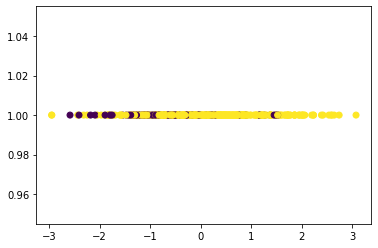

In [112]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda=LDA(n_components=1,solver="svd")

X_lda=lda.fit_transform(X[:,1:-2],y)
plt.scatter(X_lda,np.ones(len(X_lda)),c=y)


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.30, random_state=42, stratify=y)

knn=KNeighborsClassifier(n_neighbors=5,weights="distance")
test_model(knn,X_train[:,],y_train,X_test[:,:],y_test)

Train accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Test accuracy, precision, recall, F1: 0.752 0.841 0.856 0.848
[[ 8 18]
 [16 95]]
